<a href="https://colab.research.google.com/github/yseeker/pytorch-gan/blob/main/Wasserstein_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torchvision.transforms as transforms

from PIL import Image

class CFG:
    n_epoch = 2000
    batch_size = 64
    lr = 2e-4
    nch_g = 128
    nch_d = 128
    z_dim = 100
    beta1 = 0.5
    c_lower = -0.01
    c_upper = 0.01
    n_critic = 5

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

dir_path = './drive/MyDrive/result'
os.makedirs(dir_path, exist_ok = True)
dataset = dset.MNIST(root = './drive/MyDrive/data/', download = True,
                     train = True, transform = transform)
dataloader = DataLoader(dataset = dataset, batch_size=CFG.batch_size, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def save_params(file_path, epoch, netD, netG):
    torch.save(
        netG.state_dict(),
        file_path + '/g_{:04d}.pth'.format(epoch)
    )
    torch.save(
        netD.state_dict(),
        file_path + '/g_{:04d}.pth'.format(epoch)
    )

In [12]:
class Generator(nn.Module):
    def __init__(self, z_dim = 100, ngf = 128, nc = 1):
        super().__init__()
        self.convt1 = self.conv_trans_layers(z_dim, 4*ngf, 3, 1, 0)
        self.convt2 = self.conv_trans_layers(4*ngf, 2*ngf, 3, 2, 0)
        self.convt3 = self.conv_trans_layers(2*ngf, ngf, 4, 2, 1)
        self.convt4 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            nn.Tanh()
        )

    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding):
        net = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size,stride,padding, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return net

    def forward(self, x):
        out = self.convt1(x)
        out = self.convt2(out)
        out = self.convt3(out)
        out = self.convt4(out)
        return out

class Discrimnator(nn.Module):
    def __init__(self, nc = 1, ndf = 128):
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf, has_batch_norm = False)
        self.conv2 = self.conv_layers(ndf, 2*ndf)
        self.conv3 = self.conv_layers(2*ndf, 4*ndf, 3, 2, 0)
        self.conv4 = nn.Sequential(
            nn.Conv2d(4*ndf, 1, 3, 1, 0),
            nn.Sigmoid()
        )
    
    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1,
                     has_batch_norm = True):
        layers = [
                  nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        ]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        net = nn.Sequential(*layers)
        return net

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        return out

In [13]:
generator = Generator(z_dim = CFG.z_dim, ngf = CFG.nch_g).to(device)
generator.apply(weights_init)

discriminator = Discrimnator(nc = 1, ndf = CFG.nch_d).to(device)
discriminator.apply(weights_init)

criterion = nn.BCELoss()
optimizer_G = optim.RMSprop(generator.parameters(), lr = CFG.lr)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr = CFG.lr)

model_name = 'WGAN'
f_path_result = './drive/MyDrive/result/{}'.format(model_name)
f_path_params = './drive/MyDrive/result/{}'.format(model_name)

os.makedirs(f_path_result, exist_ok = True)
os.makedirs(f_path_params, exist_ok = True)

In [21]:
def train_one_step(real_imgs, noise, i):
    """train Discriminator"""
    optimizer_D.zero_grad()
    output = discriminator(real_imgs)
    lossD_real = -torch.mean(output)

    fake_imgs = generator(noise)
    output = discriminator(fake_imgs.detach())
    lossD_fake = torch.mean(output)

    lossD = lossD_real + lossD_fake
    lossD.backward()
    optimizer_D.step()

    """train Generator"""
    if i % CFG.n_critic == 0:

        optimizer_G.zero_grad()
        output = discriminator(fake_imgs)
        lossG = -torch.mean(output)
        lossG.backward()
        optimizer_G.step()
        raw_lossesG.append(lossG.item())

        return fake_imgs, lossD, lossG
    return fake_imgs, lossD

100%|██████████| 938/938 [00:34<00:00, 27.53it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0, lossD: -0.051737642396233484, lossG: -0.46414655033967644


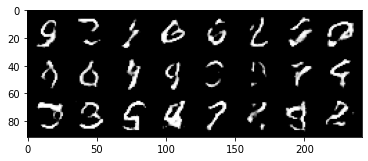

 85%|████████▍ | 793/938 [00:28<00:05, 27.35it/s]

In [ ]:
lossesD = []
lossesG = []
raw_lossesD = []
raw_lossesG = []
for epoch in range(CFG.n_epoch):
    running_lossD = 0.0
    running_lossG = 0.0
    for i, (real_imgs, labels) in enumerate(tqdm.tqdm(dataloader, position = 0)):
        for p in discriminator.parameters():
            p.data.clamp_(CFG.c_lower, CFG.c_upper)
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, CFG.z_dim, 1, 1).to(device)

        shape = (batch_size, 1, 1, 1)
        labels_real = torch.ones(shape).to(device)
        labels_fake = torch.zeros(shape).to(device)
        if i % CFG.n_critic == 0:
            fake_imgs, lossD, lossG = train_one_step(real_imgs, noise, i)
        else:
            fake_imgs, lossD = train_one_step(real_imgs, noise, i)

        running_lossD += lossD.item()
        running_lossG += lossG.item()
        raw_lossesG.append(lossD.item())

    running_lossD /= len(dataloader)
    running_lossG /= len(dataloader)
    print('epoch: {}, lossD: {}, lossG: {}'.format(epoch, running_lossD, running_lossG))
    raw_lossesD.append(running_lossD)

    # show fake imgs
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach())
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

    # save imgs and parameters
    vutils.save_image(fake_imgs, f_path_result + '/{}.jpg'.format(epoch))
    save_params(f_path_params, epoch, discriminator, generator)